# Plotting Open Flight Data with Datashader

In [1]:
import os
import pandas as pd
import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import export_image
from datashader.colors import viridis
import dask.dataframe as dd
import datetime as dt
from IPython.core.display import display, HTML
from sklearn.externals.joblib import Memory
memory = Memory(location='/tmp', verbose=0)

In [2]:
def spread(pts):
    return ((pts[0][1] - pts[0][0]),
            (pts[1][1] - pts[1][0]))
def ratio(pts):
    s = spread(pts)
    x, y = s
    return x / y

In [3]:
parq_file = r'c:\adsb\2018_Feb.parq'
ddf = dd.read_parquet(parq_file)

In [15]:
MaxBounds = ((-20048966.10, 20048966.10), (-20026376.39, 20026376.39))
WholeWorld = ((-20_037_508, 20_037_508), (-7_670_608, 13_971_466))
TwoBounds = ((-20_000_000, 20_000_000), (-20_000_000, 20_000_000))
USA_CONUS = ((-13884029, -7453304), (2698291, 6455972))
WesternEuro = ((-1181114, 4270391), (3000000, 8081620))
Germany = ((709336, 1600000), (6026907, 7270000))
Chicago = (( -9828281, -9717659), (5096658, 5161298))
Chinatown = (( -9759210, -9754583), (5137122, 5139825))
NewYorkCity = (( -8280656, -8175066), (4940514, 4998954))
LosAngeles = ((-13195052, -13114944), (3979242, 4023720))
Houston = ((-10692703, -10539441), (3432521, 3517616))
Austin = ((-10898752, -10855820), (3525750, 3550837))
NewOrleans = ((-10059963, -10006348), (3480787, 3510555))
Atlanta = ((-9507853,-9274873), (3927030, 4069506))
Southeast = ((-10_126_000, -8_903_000), (3_429_000, 4_217_000))

In [5]:
%%time
box = Atlanta
pickle_name = f'{os.path.basename(parq_file)}-ATL.p'
pickle_path = os.path.join(os.getcwd(), 'data', pickle_name)
if os.path.exists(pickle_path):
    df_atl = pd.read_pickle(pickle_path)
else:
    (x1, x2), (y1, y2) = box
    df_atl = ddf[(ddf.x > x1) & (ddf.x < x2) & (ddf.y > y1) & (ddf.y < y2)].compute()
    df_atl = df_atl.dropna(subset=['x', 'y'], how='any')
    df_atl.to_pickle(pickle_path)

Wall time: 217 ms


In [6]:
%%time
box = USA_CONUS
pickle_name = f'{os.path.basename(parq_file)}-CONUS.p'
pickle_path = os.path.join(os.getcwd(), 'data', pickle_name)
if os.path.exists(pickle_path):
    df_usa = pd.read_pickle(pickle_path)
else:
    (x1, x2), (y1, y2) = box
    df_usa = ddf[(ddf.x > x1) & (ddf.x < x2) & (ddf.y > y1) & (ddf.y < y2)].compute()
    df_usa = df_usa.dropna(subset=['x', 'y'], how='any')
    df_usa.to_pickle(pickle_path)

Wall time: 16.5 s


In [7]:
def create_image(x_range, y_range, plot_width, source=ddf, thresh=None, filename=None, spread=False):
    start = dt.datetime.now()
    cmap=viridis
    r = ratio((x_range, y_range))
    plot_height = int(plot_width / r)
    cvs = ds.Canvas(plot_width, plot_height, x_range, y_range)
    agg = cvs.points(source, 'x', 'y')
    print(f'Source contains {len(source):,} rows')
    if thresh is not None:
        agg = agg.where(agg > thresh)        
    img = tf.shade(agg, cmap = cmap)
    if spread:
        img = tf.dynspread(img, threshold=0.5, max_px=4)
    if filename is not None:
        export_image(tf.set_background(img, 'black'), filename)
    stop = dt.datetime.now()
    t = stop - start
    print(f"Image creating time: {t.total_seconds()}s")
    if filename is None:
        return tf.set_background(img, 'black')

Source contains 377,051,964 rows
Image creating time: 131.731675s


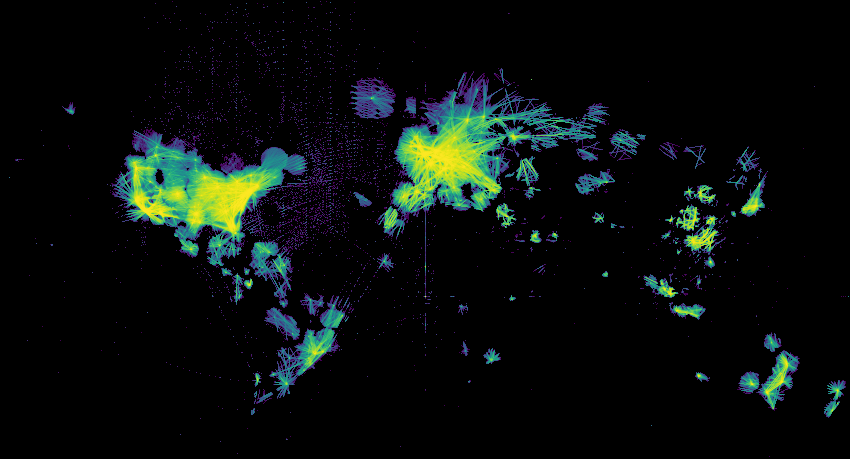

In [8]:
create_image(*WholeWorld, 850, thresh=30)

Source contains 377,051,964 rows
Image creating time: 116.74254s


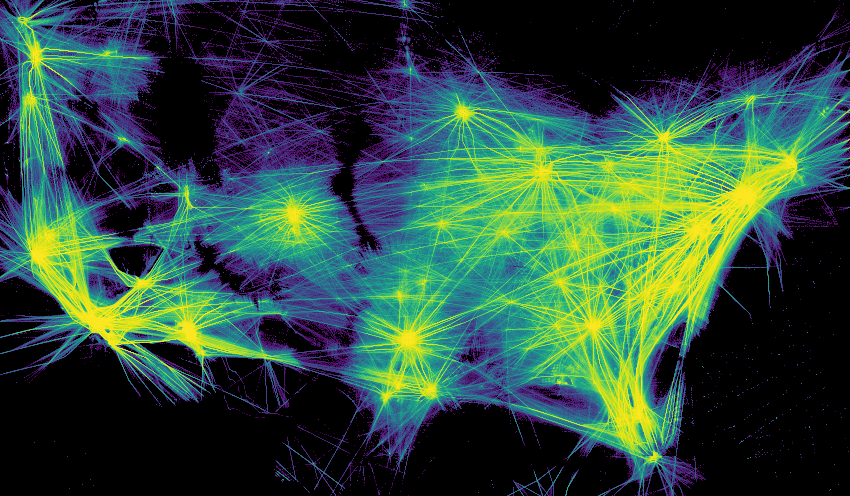

In [9]:
create_image(*USA_CONUS, 850, thresh=30)

Source contains 2,035,351 rows
Image creating time: 0.89856s


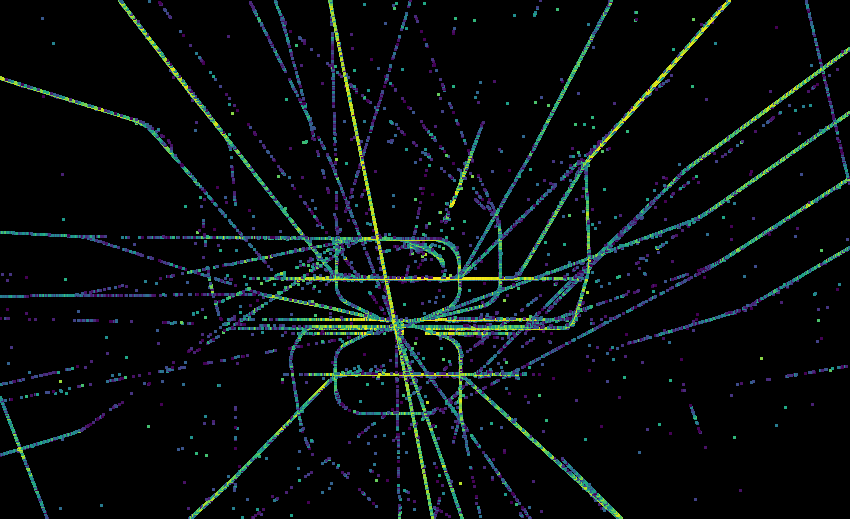

In [10]:
create_image(*Atlanta, 850, source=df_atl, thresh=25, spread=True)

Source contains 185,026,178 rows
Image creating time: 8.296773s


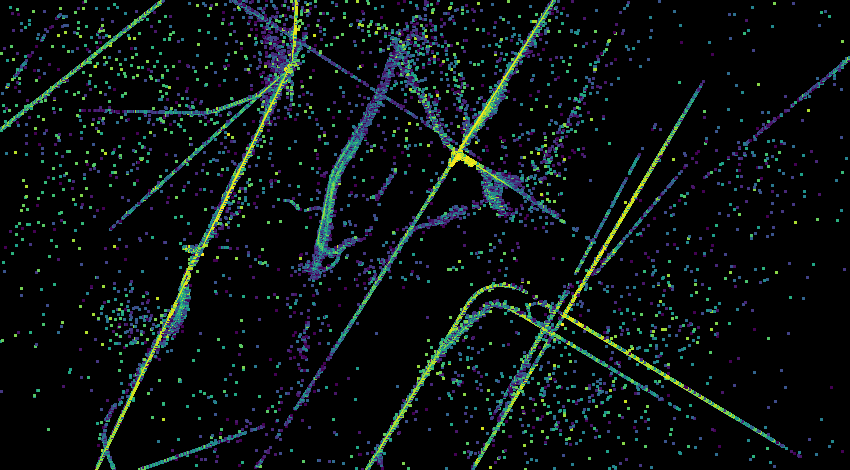

In [11]:
create_image(*NewYorkCity, 850, source=df_usa, thresh=20, spread=True)

In [12]:
fn = "USA-1920-t25.png"
create_image(*USA_CONUS, 1920, thresh=25, source=df_usa, filename=fn[:-4])
display(HTML(f"""<a href="{fn}" target="_blank">{fn}</a>"""))

In [13]:
fn = "World-1920-t30.png"
create_image(*WholeWorld, 1920, thresh=30, filename=fn,fn[:-4])
display(HTML(f"""<a href="{fn}" target="_blank">{fn}</a>"""))

In [17]:
fn = "Southeast-1920-t30.png"
create_image(*Southeast, 1920, thresh=30, filename=fn[:-4])
display(HTML(f"""<a href="{fn}" target="_blank">{fn}</a>"""))

Source contains 377,051,964 rows
Image creating time: 109.551998s
